In [1]:
import numpy as np
from clawpack.pyclaw import Solution
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy as sp
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import xarray as xr

In [2]:
def read_fortq(frame):
    """
    Import fort.q files to get x,y,z data
    """
    fortq = Solution(frame, file_format='ascii')
    patch_dict = {}
    for stateno, state in enumerate(fortq.states):
        patch = state.patch
        this_level = patch.level
        Xc, Yc = state.grid.c_centers
        mask_coarse = np.empty(Xc.shape, dtype=bool)
        mask_coarse.fill(False)
        for stateno_fine, state_fine in enumerate(fortq.states):
            patch_fine = state_fine.patch
            if patch_fine.level != this_level+1:
                continue
            xlower_fine = patch_fine.dimensions[0].lower
            xupper_fine = patch_fine.dimensions[0].upper
            ylower_fine = patch_fine.dimensions[1].lower
            yupper_fine = patch_fine.dimensions[1].upper

            m1 = (Xc > xlower_fine) & (Xc < xupper_fine)
            m2 = (Yc > ylower_fine) & (Yc < yupper_fine)
            mask_coarse = (m1 & m2) | mask_coarse
        
        h = state.q[0,:,:]
        eta = state.q[3,:,:]
        drytol_default = 0.001
        water = np.copy(eta)
        idx = np.where(h<=drytol_default)
        water[idx] = np.NaN
        
#         water[mask_coarse == True] = np.NaN  
        
        # Save variables to dictionary
        long=Xc[:,0]
        lat = Yc[0]
        patch_dict[stateno] = {"lat": lat, 'long':long, 'eta':eta, 'amr_level':this_level, 'Xc':Xc, 'Yc':Yc, 'water':water}
    return patch_dict

In [3]:
patch_dict = read_fortq(4)

In [4]:
def combine_patches(patch):
    # Loop through all the patches, extra lat/lon and water level then append to a dataframe
    lat = patch['Yc'][0]
    lon = patch['Xc'][:,0]
    water = patch['water']
    df = pd.DataFrame(data=water, index=[i for i in lon], columns=[i for i in lat])# 'Latitude':lat, 'Longitude':long})
    df.index.name='Longitude'
    df.columns.name="Latitude"
    return df

# Set up 6 empty lists to go with 6 different patch levels
da1 = []
da2 = []
da3 = []
da4 = []
da5 = []
da6 = []

for patch_no in patch_dict: 
    if patch_dict[patch_no]['amr_level'] == 1:
        da1 = combine_patches(patch_dict[patch_no])
    if  patch_dict[patch_no]['amr_level'] == 2:
        df = combine_patches(patch_dict[patch_no])
        da2.append(df)
    if patch_dict[patch_no]['amr_level'] == 3:
        df = combine_patches(patch_dict[patch_no])
        da3.append(df)
    if patch_dict[patch_no]['amr_level'] == 4:
        df = combine_patches(patch_dict[patch_no])
        da4.append(df)
    if patch_dict[patch_no]['amr_level'] == 5:
        df = combine_patches(patch_dict[patch_no])
        da5.append(df)
    if patch_dict[patch_no]['amr_level'] == 6:
        df = combine_patches(patch_dict[patch_no])
        da6.append(df)

In [11]:
def clean_patches(patch_list):
    # Add new patch data into a dataframe so all patches with the same amr_level are in one frame
    df_comb = pd.concat(patch_list)
    # Arrange by lat/lon
    df_sort = df_comb.groupby(level=0).sum()
    df_sort.sort_index(axis=0)
    # Groupby removed nan and replaces with 0, replace 0 with nan
    df_sort.replace(0.00, np.nan, inplace=True)
    return df_sort

def convert_to_xarray(df):
    da = xr.DataArray(df.T)
    return da

def plot_patches(da):
    from clawpack.geoclaw import geoplot
    map_limits = [-130.0, -120.0, 40.0, 51.0]
    clines_zeta = [0.0] + list(np.linspace(0.05,0.3,6)) + [0.5,1.0,1.5]
    colors = geoplot.discrete_cmap_1(clines_zeta)
    ax = fig.add_subplot(121, projection=ccrs.PlateCarree(map_limits))
    ax.set_extent(map_limits)
    ax.coastlines(resolution='10m')
    da.plot.contourf(x='Longitude', y='Latitude', add_colorbar=False, vmin=-0.1, vmax=0.1, ax=ax, colors=colors, alpha=0.7)
        
def create_dataset(da):
    # Change data array to dataset to be able to save as netcdf bathymetry style grids
    da = xr.DataArray(da, name='z')
    ds = da.to_dataset()
    return ds

def save_netcdf(ds, idx):
    # should probably make this more generic to loop through all fort.q files
    zmin = float(ds.z.min())
    zmax = float(ds.z.max())
    ds.z.attrs['actual_range'] = [zmin, zmax]
    ds.to_netcdf(f'frame4_{idx}.nc')
    
def interp_grids(grid):
    # interpolate grids to finer levels but also even out patch dimensions
    new_lon = np.linspace(ds.Longitude[0], ds.Longitude[-1], ds.dims['Longitude']*4)
    new_lat = np.linspace(ds.Latitude[0], ds.Latitude[-1], ds.dims['Latitude']*4)
    dsi = ds.interp(Latitude=new_lat, Longitude=new_lon)
    return dsi

<ipython-input-11-8f34ca02df48>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(121, projection=ccrs.PlateCarree(map_limits))


PermissionError: [Errno 13] Permission denied: b'/mnt/c/Projects/GMT/frame4_5.nc'

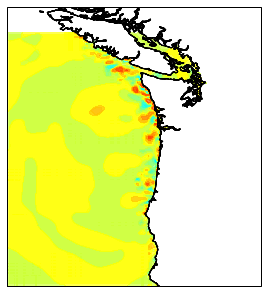

In [14]:
patch_vars = [da1, da2, da3, da4, da5, da6]
fig = plt.figure(figsize=[10,7])
for i in range(6):
    patch_list = patch_vars[i]
    if i == 0:
        da = convert_to_xarray(patch_list)
        plot_patches(da)
        ds = create_dataset(da)
        dsi = interp_grids(ds) # make grids have even spacing
        save_netcdf(ds, i)
    else:
        df = clean_patches(patch_list)
        da = convert_to_xarray(df)
        plot_patches(da)
        ds = create_dataset(da)
        dsi = interp_grids(ds) # make grids have even spacing
        save_netcdf(ds, i)

In [9]:
da = xr.DataArray(da, name='z')
da

<xarray.DataArray 'z' (Latitude: 50, Longitude: 50)>
array([[-4.63442497e-03, -6.05167070e-03, -7.92642915e-03, ...,
                    nan,             nan,             nan],
       [-6.28571341e-03, -7.68588990e-03, -9.40146242e-03, ...,
                    nan,             nan,             nan],
       [-9.54046568e-03, -1.03673035e-02, -1.07180192e-02, ...,
                    nan,             nan,             nan],
       ...,
       [ 1.37040456e-03,  1.62596829e-03,  1.77115215e-03, ...,
                    nan,             nan,             nan],
       [-5.22219771e-04, -6.40525614e-05,  1.69119447e-04, ...,
                    nan,             nan,             nan],
       [-3.24931949e-03, -2.27028157e-03, -6.24806694e-04, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Latitude   (Latitude) float64 40.1 40.3 40.5 40.7 ... 49.3 49.5 49.7 49.9
  * Longitude  (Longitude) float64 -129.9 -129.7 -129.5 ... -120.5 -120.3 -120.1

In [ ]:
water = ds.z.sel[Longitude=-127.0, Latitude=41.1]